In [41]:
import numpy as np
import random
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
import torch
from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# Common functions
LABEL2INDEX = {'positive': 0, 'neutral': 1, 'negative': 2}
INDEX2LABEL = {0: 'positive', 1: 'neutral', 2: 'negative'}
NUM_LABELS = 3

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [3]:
# Set random seed
set_seed(20250702)

### Load Model

In [4]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Prepare Dataset

In [5]:
# Processing Datasets
def load_dataset(path):
    df = pd.read_csv(path, sep='\t', header=None)
    df.columns = ['text', 'sentiment']
    df['sentiment'] = df['sentiment'].apply(lambda lab: LABEL2INDEX[lab])
    return df

def encode_dataset(df, tokenizer, no_special_token=False):
    encoded = []
    for _, row in df.iterrows():
        text = row['text']
        sentiment = row['sentiment']
        subwords = tokenizer.encode(text, add_special_tokens=not no_special_token)
        encoded.append((np.array(subwords), np.array(sentiment), text))
    return encoded

def collate_fn(batch, max_seq_len=512):
    batch_size = len(batch)
    max_len = min(max(len(x[0]) for x in batch), max_seq_len)
    
    subword_batch = np.zeros((batch_size, max_len), dtype=np.int64)
    mask_batch = np.zeros((batch_size, max_len), dtype=np.float32)
    sentiment_batch = np.zeros((batch_size, 1), dtype=np.int64)
    seq_list = []

    for i, (subwords, sentiment, raw_seq) in enumerate(batch):
        subwords = subwords[:max_len]
        subword_batch[i, :len(subwords)] = subwords
        mask_batch[i, :len(subwords)] = 1
        sentiment_batch[i, 0] = sentiment
        seq_list.append(raw_seq)

    return (
        torch.tensor(subword_batch),
        torch.tensor(mask_batch),
        torch.tensor(sentiment_batch),
        seq_list
    )

In [ ]:
train_dataset_path = '/content/drive/MyDrive/sentika/data/train_preprocess.tsv'
valid_dataset_path = '/content/drive/MyDrive/sentika/data/valid_preprocess.tsv'
test_dataset_path = '/content/drive/MyDrive/sentika/data/test_preprocess.tsv'

In [ ]:
train_df = load_dataset(train_dataset_path)
valid_df = load_dataset(valid_dataset_path)
test_df  = load_dataset(test_dataset_path)

In [ ]:
train_encoded = encode_dataset(train_df, tokenizer)
valid_encoded = encode_dataset(valid_df, tokenizer)
test_encoded  = encode_dataset(test_df, tokenizer)

In [ ]:
train_loader = DataLoader(
    train_encoded, batch_size=32, shuffle=True, num_workers=16,
    collate_fn=lambda x: collate_fn(x, max_seq_len=512)
)

valid_loader = DataLoader(
    valid_encoded, batch_size=32, shuffle=False, num_workers=16,
    collate_fn=lambda x: collate_fn(x, max_seq_len=512)
)

test_loader = DataLoader(
    test_encoded, batch_size=32, shuffle=False, num_workers=16,
    collate_fn=lambda x: collate_fn(x, max_seq_len=512)
)

In [26]:
w2i, i2w = LABEL2INDEX, INDEX2LABEL
print(w2i)
print(i2w)

train_df

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


,text,sentiment,token_count
0,warung ini dimiliki oleh pengusaha pabrik tahu...,0,73
1,mohon ulama lurus dan k212 mmbri hujjah partai...,1,26
2,lokasi strategis di jalan sumatera bandung . t...,0,40
3,betapa bahagia nya diri ini saat unboxing pake...,0,21
4,duh . jadi mahasiswa jangan sombong dong . kas...,2,43
...,...,...,...
10995,tidak kecewa,0,4
10996,enak rasa masakan nya apalagi kepiting yang me...,0,28
10997,hormati partai-partai yang telah berkoalisi,1,11
10998,"pagi pagi di tol pasteur sudah macet parah , b...",2,15


### Fine tuning and evaluation

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=5e-6)
model = model.cuda()

In [ ]:
def forward_sequence_classification(model, batch_data, i2w, is_test=False, device='cuda'):
    """
    Forward function for sequence classification.
    
    Parameters:
        model      : torch.nn.Module
        batch_data : tuple of (input_ids, attention_mask, [token_type_ids], labels)
        i2w        : dict, index to label mapping
        is_test    : bool, whether test mode (optional)
        device     : str or torch.device
    
    Returns:
        loss       : torch.Tensor
        list_hyp   : list of predicted labels
        list_label : list of ground truth labels
    """
    
    # Move data to tensors
    if len(batch_data) == 3:
        input_ids, attention_mask, labels = batch_data
        token_type_ids = None
    else:
        input_ids, attention_mask, token_type_ids, labels = batch_data
    
    input_ids = torch.as_tensor(input_ids).to(device)
    attention_mask = torch.as_tensor(attention_mask).to(device)
    labels = torch.as_tensor(labels).to(device)
    
    if token_type_ids is not None:
        token_type_ids = torch.tensor(token_type_ids).to(device)

    # Forward pass
    outputs = model(
        input_ids, 
        attention_mask=attention_mask, 
        token_type_ids=token_type_ids, 
        labels=labels
    )
    loss, logits = outputs[:2]

    # Get predictions
    preds = torch.argmax(logits, dim=1)
    
    list_hyp = [i2w[p.item()] for p in preds]
    list_label = [i2w[l.item()] for l in labels]

    return loss, list_hyp, list_label

def document_sentiment_metrics_fn(list_hyp, list_label):
    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average='macro')
    metrics["REC"] = recall_score(list_label, list_hyp, average='macro')
    metrics["PRE"] = precision_score(list_label, list_hyp, average='macro')
    return metrics

In [ ]:
# Training model
n_epochs = 20
train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(
            model, batch_data[:-1], i2w=i2w, device='cuda'
        )

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss += tr_loss

        # Track predictions
        list_hyp += batch_hyp
        list_label += batch_label

        current_lr = optimizer.param_groups[0]['lr']
        train_pbar.set_description(
            f"(Epoch {epoch+1}) TRAIN LOSS:{total_train_loss/(i+1):.4f} LR:{current_lr:.8f}"
        )

    # Train metrics
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print(f"(Epoch {epoch+1}) TRAIN LOSS:{total_train_loss/(i+1):.4f} {metrics_to_string(metrics)} "
        f"LR:{current_lr:.8f}")
    avg_train_loss = total_train_loss / (i + 1)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss = 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(
            model, batch_data[:-1], i2w=i2w, device='cuda'
        )

        total_loss += loss.item()
        list_hyp += batch_hyp
        list_label += batch_label

        metrics = document_sentiment_metrics_fn(list_hyp, list_label)
        pbar.set_description(
            f"VALID LOSS:{total_loss/(i+1):.4f} {metrics_to_string(metrics)}"
        )

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print(f"(Epoch {epoch+1}) VALID LOSS:{total_loss/(i+1):.4f} {metrics_to_string(metrics)}")
    avg_valid_loss = total_loss / (i + 1)
    valid_losses.append(avg_valid_loss)

    # Save model to Google Drive
    save_path = f"/content/drive/MyDrive/sentika/model_epoch_{epoch+1}.pt"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

In [25]:
# Evaluate on test
model.load_state_dict(torch.load("../backend/model/smsa-model.pt", map_location='cpu'))
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cpu')
    list_hyp += batch_hyp
    list_label += batch_label
metrics = document_sentiment_metrics_fn(list_hyp, list_label)
print("TEST Metrics | {}".format(metrics_to_string(metrics)))

100%|██████████| 16/16 [00:27<00:00,  1.69s/it]

TEST Metrics | ACC:0.91 F1:0.89 REC:0.87 PRE:0.90


### Testing model from .csv file and sample sentences

In [31]:
# Labeling data
model.load_state_dict(torch.load("../backend/model/smsa-model.pt", map_location='cpu'))
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_label_loader, leave=True, total=len(test_label_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cpu')
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'label':list_hyp}).reset_index()
df.to_csv('pred.csv', index=False)

df

100%|██████████| 16/16 [00:29<00:00,  1.86s/it]


,index,label
0,0,negative
1,1,negative
2,2,negative
3,3,negative
4,4,negative
...,...,...
495,495,neutral
496,496,neutral
497,497,neutral
498,498,positive


In [36]:
# Combine and compare with true
print(test_df.columns)

combined_test_df = test_df
# combined_test_df['sentiment'] = combined_test_df['sentiment'].apply(lambda lab: i2w[lab])
combined_test_df['label'] = df['label'].values
combined_test_df.to_csv('../data/output/combined-test-label.csv', index=False)

Index(['text', 'sentiment', 'label'], dtype='object')


In [38]:
combined_test_df = pd.read_csv('../data/output/combined-test-label.csv', header=0)
combined_test_df

,text,sentiment,label
0,kemarin gue datang ke tempat makan baru yang a...,negative,negative
1,kayak nya sih gue tidak akan mau balik lagi ke...,negative,negative
2,"kalau dipikir-pikir , sebenarnya tidak ada yan...",negative,negative
3,ini pertama kalinya gua ke bank buat ngurusin ...,negative,negative
4,waktu sampai dengan gue pernah disuruh ibu lat...,negative,negative
...,...,...,...
495,kata nya tidur yang baik itu minimal enam jam ...,neutral,neutral
496,indonesia itu ada di benua asia .,neutral,neutral
497,salah satu kegemaran anak remaja indonesia sek...,neutral,neutral
498,melihat warna hijau bisa bikin mata jadi lebih...,positive,positive


              precision    recall  f1-score   support

    positive       0.93      0.99      0.96       204
     neutral       0.87      0.70      0.78        88
    negative       0.91      0.93      0.92       208

    accuracy                           0.91       500
   macro avg       0.90      0.87      0.89       500
weighted avg       0.91      0.91      0.91       500



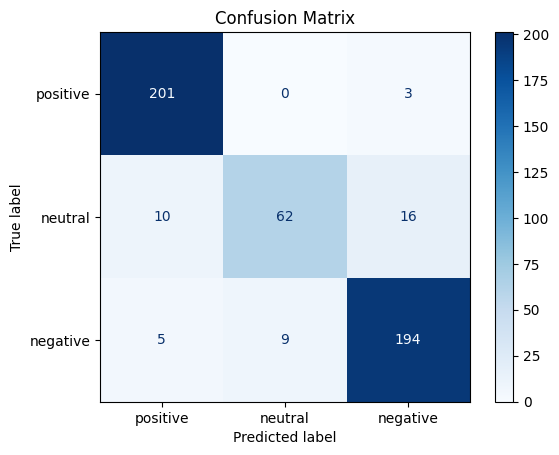

In [39]:
y_true = combined_test_df['sentiment'].tolist()
y_pred = combined_test_df['label'].tolist()

print(classification_report(y_true, y_pred, target_names=INDEX2LABEL.values()))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=INDEX2LABEL.values())
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [30]:
model.load_state_dict(torch.load("../backend/model/smsa-model.pt", map_location='cpu'))
model.eval()
torch.set_grad_enabled(False)

In [31]:
text = 'bagus banget fotonya itu'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: bagus banget fotonya itu | Label : positive (99.888%)


In [32]:
text = 'pagi tadi pergi ke BLI'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: pagi tadi pergi ke BLI | Label : neutral (99.787%)


In [33]:
text = 'Dasar anak sialan!! Kurang ajar!!'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Dasar anak sialan!! Kurang ajar!! | Label : negative (99.885%)


### Prepare Lazada's reviews dataset

DO NOT RUN THIS SCRIPT AGAIN!!!

In [14]:
# Testing with Lazada Indonesian Reviews
lazada_reviews_path = '../data/lazada_reviews/lazada-reviews-without-sentiment.csv'

# Remove unused columns and remove missing values
lazada_df = pd.read_csv(lazada_reviews_path, header=None, low_memory=False)
lazada_df.columns = lazada_df.iloc[0]
lazada_df = lazada_df[1:]
lazada_df = lazada_df.reset_index(drop=True)
lazada_df = lazada_df[['reviewContent']].rename(columns={'reviewContent': 'text'})
lazada_df = lazada_df.dropna()
lazada_df['sentiment'] = 'isi ini ya ges (positive/neutral/negative)'

sample_df = lazada_df.sample(n=11000, random_state=42).reset_index(drop=True)
sample_df.to_csv('../data/lazada_reviews/train-lazada.csv')

In [ ]:
remaining_df = lazada_df[~lazada_df['text'].isin(sample_df['text'])]

test_df = remaining_df.sample(n=500, random_state=99).reset_index(drop=True)
test_df.to_csv('../data/lazada_reviews/test-lazada.csv')

In [ ]:
used_texts = set(sample_df['text']) | set(test_df['text'])

new_remaining_df = lazada_df[~lazada_df['text'].isin(used_texts)]

valid_df = remaining_df.sample(n=1260, random_state=123).reset_index(drop=True)
valid_df.to_csv('../data/lazada_reviews/valid-lazada.csv')

valid_df

YOU CAN RUN AFTER THIS

In [17]:
lazada_train_dataset_path = '../data/lazada_reviews/train-lazada.csv'
lazada_valid_dataset_path = '../data/lazada_reviews/valid-lazada.csv'
lazada_test_dataset_path = '../data/lazada_reviews/test-lazada.csv'
# lazada_test_labeling_path = '../data/smsa/test.csv'

In [18]:
def load_dataset_csv(path):
    df = pd.read_csv(path, header=0)
    # df.columns = ['text', 'sentiment']
    df['sentiment'] = 'neutral'
    df['sentiment'] = df['sentiment'].apply(lambda lab: LABEL2INDEX[lab])
    return df

def load_dataset_empty(path):
    df = pd.read_csv(path)
    df['sentiment'] = 'neutral'
    return df

In [32]:
lazada_train_df = load_dataset_csv(lazada_train_dataset_path)
lazada_train_df = lazada_train_df.drop(columns=['Unnamed: 0'])
lazada_valid_df = load_dataset_csv(lazada_valid_dataset_path)
lazada_valid_df = lazada_valid_df.drop(columns=['Unnamed: 0'])
lazada_test_df  = load_dataset_csv(lazada_test_dataset_path)
lazada_test_df = lazada_test_df.drop(columns=['Unnamed: 0'])
# test_label_df = load_dataset(lazada_test_labeling_path)

In [33]:
lazada_train_encoded = encode_dataset(lazada_train_df, tokenizer)
lazada_valid_encoded = encode_dataset(lazada_valid_df, tokenizer)
lazada_test_encoded  = encode_dataset(lazada_test_df, tokenizer)
# lazada_test_label_encoded = encode_dataset(lazada_test_label_df, tokenizer)

In [34]:
lazada_test_df

,text,sentiment
0,barang diterima dlm keadaan kypet tidak berfun...,1
1,kualitas fungsi barang oke,1
2,SESUAI PESANAN,1
3,pengiriman lama sekali dioper2 oleh ninja expr...,1
4,Barang bagus. Original dengan harga miring. Th...,1
...,...,...
495,"awal nya sih senang uda datang hardisk ini, eh...",1
496,mantuuuuuuuuul beli 3biji pecah satu.. tapi ko...,1
497,oke banget...thx,1
498,Polytron dari dulu terkenal bagus dalam produk...,1


In [35]:
lazada_train_label_loader = DataLoader(
    lazada_train_encoded, batch_size=32, shuffle=False, num_workers=8,
    collate_fn=lambda x: collate_fn(x, max_seq_len=512)
)

lazada_valid_label_loader = DataLoader(
    lazada_valid_encoded, batch_size=32, shuffle=False, num_workers=8,
    collate_fn=lambda x: collate_fn(x, max_seq_len=512)
)

lazada_test_label_loader = DataLoader(
    lazada_test_encoded, batch_size=32, shuffle=False, num_workers=8,
    collate_fn=lambda x: collate_fn(x, max_seq_len=512)
)

In [41]:
# Test Lazada's
# Labeling data
model.load_state_dict(torch.load("../backend/model/smsa-model.pt", map_location='cpu'))
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label, list_text = [], [], []

pbar = tqdm(lazada_test_label_loader, leave=True, total=len(lazada_test_label_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cpu')
    list_hyp += batch_hyp

# Save prediction
df = pd.DataFrame({'text':lazada_test_df['text'], 'label':list_hyp})
df.to_csv('../data/output/lazada-test.csv', index=False)

100%|██████████| 16/16 [00:45<00:00,  2.84s/it]


In [42]:
df

,text,label
0,barang diterima dlm keadaan kypet tidak berfun...,negative
1,kualitas fungsi barang oke,positive
2,SESUAI PESANAN,positive
3,pengiriman lama sekali dioper2 oleh ninja expr...,negative
4,Barang bagus. Original dengan harga miring. Th...,positive
...,...,...
495,"awal nya sih senang uda datang hardisk ini, eh...",positive
496,mantuuuuuuuuul beli 3biji pecah satu.. tapi ko...,negative
497,oke banget...thx,positive
498,Polytron dari dulu terkenal bagus dalam produk...,positive


In [43]:
lazada_test_df

,text,sentiment
0,barang diterima dlm keadaan kypet tidak berfun...,1
1,kualitas fungsi barang oke,1
2,SESUAI PESANAN,1
3,pengiriman lama sekali dioper2 oleh ninja expr...,1
4,Barang bagus. Original dengan harga miring. Th...,1
...,...,...
495,"awal nya sih senang uda datang hardisk ini, eh...",1
496,mantuuuuuuuuul beli 3biji pecah satu.. tapi ko...,1
497,oke banget...thx,1
498,Polytron dari dulu terkenal bagus dalam produk...,1
